In [1]:
import os
import random
import torch
import importlib
import src.util as util
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm 


In [2]:
path=os.getcwd()
path

'/media/data/home/darcy/master_summary'

In [3]:
file=pd.read_csv(path+'/datasets/household_consumption.csv').loc[3186:13097] #  2007/05/01 00:00~2008/06/16 23:00
file.info()

datetime=file['Datetime'] 

file=file.drop(columns=['Datetime'])


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9912 entries, 3186 to 13097
Data columns (total 8 columns):
Global_active_power      9912 non-null float64
Global_reactive_power    9912 non-null float64
Voltage                  9912 non-null float64
Global_intensity         9912 non-null float64
Sub_metering_1           9912 non-null float64
Sub_metering_2           9912 non-null float64
Sub_metering_3           9912 non-null float64
Datetime                 9912 non-null object
dtypes: float64(7), object(1)
memory usage: 619.6+ KB


In [4]:
file.loc[3186:10001]

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
3186,0.303800,0.150567,237.574667,1.443333,0.0,0.266667,0.000000
3187,0.256633,0.132367,236.393000,1.220000,0.0,0.733333,0.000000
3188,0.198700,0.071667,236.211167,0.890000,0.0,0.000000,0.000000
3189,0.256767,0.151567,236.648833,1.263333,0.0,0.933333,0.000000
3190,0.189433,0.063100,237.063667,0.873333,0.0,0.066667,0.000000
...,...,...,...,...,...,...,...
9997,1.574600,0.071200,237.241500,6.723333,0.0,0.100000,0.000000
9998,1.263800,0.044167,237.959000,5.420000,0.0,0.000000,0.000000
9999,1.258933,0.097333,238.576000,5.460000,0.0,0.383333,0.000000
10000,2.007733,0.082133,239.261167,8.440000,0.0,0.216667,0.000000


In [4]:
#training data: 2007/05/01 00:00 (3186) ~ 2008/02/08 23:00 (10001), testing data: 2008/02/09 00:00 (10002)~2008/06/16 23:00 (13097)
data=(file-file.loc[3186:10001].min())/(file.loc[3186:10001].max()-file.loc[3186:10001].min()) 
scale=[file.loc[3186:10001].max().tolist(),file.loc[3186:10001].min().tolist()]
data1=data.values

In [12]:
data

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
3186,0.025965,0.247127,0.505827,0.029618,0.000000,0.005743,0.000000
3187,0.018546,0.210649,0.454915,0.021518,0.000000,0.015793,0.000000
3188,0.009433,0.088990,0.447081,0.009550,0.000000,0.000000,0.000000
3189,0.018567,0.249131,0.465938,0.023090,0.000000,0.020101,0.000000
3190,0.007975,0.071820,0.483811,0.008946,0.000000,0.001436,0.000000
...,...,...,...,...,...,...,...
13093,0.160278,0.472675,0.704974,0.161267,0.000000,0.007179,0.349107
13094,0.218368,0.387427,0.620937,0.211799,0.000000,0.005743,0.982143
13095,0.435227,0.393974,0.562434,0.420334,0.115782,0.007179,1.013393
13096,0.234214,0.256480,0.671511,0.223404,0.049966,0.005384,0.490179


In [5]:
file=pd.read_csv(path+'/datasets/household_consumption.csv').loc[3186:13097] #  2007/05/01 00:00~2008/06/16 23:00
file

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Datetime
3186,0.303800,0.150567,237.574667,1.443333,0.000000,0.266667,0.000000,2007/05/01 00:00
3187,0.256633,0.132367,236.393000,1.220000,0.000000,0.733333,0.000000,2007/05/01 01:00
3188,0.198700,0.071667,236.211167,0.890000,0.000000,0.000000,0.000000,2007/05/01 02:00
3189,0.256767,0.151567,236.648833,1.263333,0.000000,0.933333,0.000000,2007/05/01 03:00
3190,0.189433,0.063100,237.063667,0.873333,0.000000,0.066667,0.000000,2007/05/01 04:00
...,...,...,...,...,...,...,...,...
13093,1.157667,0.263100,242.196833,5.073333,0.000000,0.333333,6.516667,2008/06/16 19:00
13094,1.526967,0.220567,240.246333,6.466667,0.000000,0.266667,18.333333,2008/06/16 20:00
13095,2.905600,0.223833,238.888500,12.216667,5.600000,0.333333,18.916667,2008/06/16 21:00
13096,1.627700,0.155233,241.420167,6.786667,2.416667,0.250000,9.150000,2008/06/16 22:00


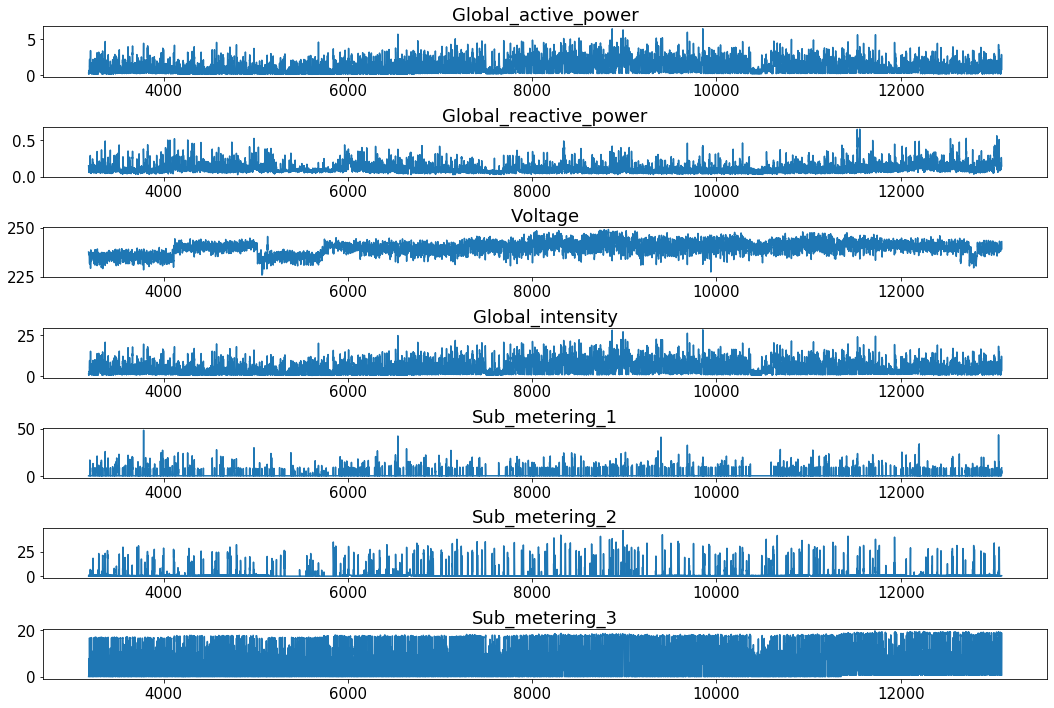

In [6]:
plt.figure(figsize=(18,12))
plt.rc('font',size=15)
for i in range(len(file.columns)):
    plt.subplot(711+i)
    plt.plot(file[file.columns[i]])
    plt.title(file.columns[i],rotation=0)
plt.subplots_adjust(hspace = 1.0)
#plt.legend(data.columns,loc='upper left')

In [5]:
[file[3186:10001].max().tolist(),file[3186:10001].min().tolist()]

[[6.496033333333336,
  0.6540666666666668,
  249.04433333333333,
  28.2,
  43.38333333333333,
  46.43333333333333,
  19.733333333333334],
 [0.1486666666666666,
  0.027266666666666682,
  227.422,
  0.6933333333333328,
  0.0,
  0.0,
  0.0]]

In [18]:
data.columns

Index(['Global_active_power', 'Global_reactive_power', 'Voltage',
       'Global_intensity', 'Sub_metering_1', 'Sub_metering_2',
       'Sub_metering_3'],
      dtype='object')

# generate inputs and outputs

In [5]:
def make_neighbor_list(target, input_dim):
    neighbors=[target]
    for i in range(input_dim):
        if i == target:
            continue
        else:
            neighbors.append(i)

    return neighbors


def make_io(data, input_len,output_len,neighbors,split_size,shuffle=True):
    dataset1=[] #training dataset
    dataset2=[] #testing dataset
    package1=[[],[],[]]
    package2=[[],[],[]]
    data_len=data1.shape[0]
    data_dim=data1.shape[1]

    
    
    for j in range(data_len-input_len-output_len):
        one_x=[]
        one_y=[]
        i=neighbors[0]
        s=[scale[0][i],scale[1][i]] #min/ max
        for k in neighbors:
            one_x.append(data[j:j+input_len,k].reshape(input_len,-1))
            one_y.append(data[j+input_len:j+input_len+output_len,k].reshape(output_len,-1))
                
        one_x=np.concatenate(one_x,axis=1)
        one_y=np.concatenate(one_y,axis=1)
        one_data=[one_x.tolist(),one_y.tolist(),s]
            
        if j<(data_len-split_size):
            dataset1.append(one_data)
        else:
            dataset2.append(one_data)
    if shuffle:
        random.shuffle(dataset1)
        random.shuffle(dataset2)
   
    for i in range(len(dataset1)):
        package1[0].append(dataset1[i][0])
        package1[1].append(dataset1[i][1])
        package1[2].append(dataset1[i][2])
    
    for i in range(len(dataset2)):
        package2[0].append(dataset2[i][0])
        package2[1].append(dataset2[i][1])
        package2[2].append(dataset2[i][2])
    #return dataset1,dataset2

    return package1, package2


In [9]:
input_len=24
output_len=12
split=3096
input_dim=7
inputs=make_neighbor_list(0, input_dim)
dataset1,dataset2=make_io(input_len,output_len,inputs,split,False)
X_train=torch.FloatTensor(dataset1[0])
Y_train=torch.FloatTensor(dataset1[1])[:,:,0].unsqueeze(2)
X_test=torch.FloatTensor(dataset2[0])
Y_test=torch.FloatTensor(dataset2[1])[:,:,0].unsqueeze(2)
X_train.shape, X_test.shape

(torch.Size([6816, 24, 7]), torch.Size([3060, 24, 7]))

# training function

In [7]:
def train(data, inputs, epochs, input_dim, input_len, output_len, split, model, loss_func, folder, constrain=False):
    
    testing_mae=0
    testing_mape=0
    
    target=inputs[0]
    print(file.columns[target])
    
    
    dataset1,dataset2=make_io(data,input_len,output_len,inputs,split)
    dataset3,dataset4=make_io(data, input_len,output_len,inputs,split,False)

    X_train=torch.FloatTensor(dataset1[0])
    Y_train=torch.FloatTensor(dataset1[1])[:,:,0].unsqueeze(2)
    S_train=torch.FloatTensor(dataset1[2])

    X_test=torch.FloatTensor(dataset2[0])
    Y_test=torch.FloatTensor(dataset2[1])[:,:,0].unsqueeze(2)
    S_test=torch.FloatTensor(dataset2[2])

    X_train_valid=torch.FloatTensor(dataset3[0])
    Y_train_valid=torch.FloatTensor(dataset3[1])[:,:,0].unsqueeze(2)
    S_train_valid=torch.FloatTensor(dataset3[2])

    X_test_valid=torch.FloatTensor(dataset4[0])
    Y_test_valid=torch.FloatTensor(dataset4[1])[:,:,0].unsqueeze(2)
    S_test_valid=torch.FloatTensor(dataset4[2])
        
    model.to(gpu) #model放到gpu裡
    print('number of parmeters:', util.count_parameters(model))
    
    for j in range(epochs):
        if j<500:
            rate=0.001
        elif j>500 and j<2000:
            rate=0.0001
        else:
            rate=0.00001
            
        opt=torch.optim.Adam(model.parameters(),lr=rate)
        
        if constrain:
            model.weight.data.clamp_(0,1)
  
        #compute_loss(model, feature, label, batch, opt, train, loss_func, device)
        training_loss=util.compute_loss(model, X_train, Y_train, batch, opt, loss_func, train=True,device=gpu)
        testing_loss=util.compute_loss(model,X_test,Y_test,batch,opt, loss_func, train=False,device=gpu)
        test_mape=util.mape(model(X_test.to(gpu))[:,:,0].to(cpu),Y_test[:,:,0],(scale[0][i]-scale[1][i]),scale[1][i])
        
        #training_loss=util.compute_loss_ver2(model, X_train, Y_train, batch, opt, loss_func, train=True,device=gpu)
        #testing_loss=util.compute_loss_ver2(model,X_test,Y_test,batch,opt, loss_func, train=False,device=gpu)
        #test_mape=util.mape(model(X_test.to(gpu))[0][:,:,0].to(cpu),Y_test[:,:,0],(scale[0][i]-scale[1][i]),scale[1][i])
        
        
        if j%100==0:
            print('epoch:'+str(j))
            print('training mae loss:'+str(training_loss))
            print('testing mae loss:'+str(testing_loss))
            print('testing mape:'+str(test_mape))
            if constrain:
                print(model.weight.data)
    
    
    model.to(cpu)   
     # plot_result(model, xs, ys, output_len, title, target_series, scale, save_path)
    util.plot_result(model, [X_train_valid,X_test_valid],[Y_train_valid,Y_test_valid],output_len,file.columns[target], target, 
                     scale, path+ '/results/plots/household_consumption/'+method+'/')
    
    #plt.savefig(path+ '/results/plots/exchange_rate/'+data.columns[target]+'_prediction.png')
    #plt.clf()
    #    testing_mae+=testing_loss
    #    testing_mape+=mape(model(X_test)[:,:,0],Y_test[:,:,0],(scale[0][i]-scale[1][i]),scale[1][i])
    
   
    return X_train_valid, Y_train_valid, X_test_valid, Y_test_valid
    

# set gpu and loss function

In [8]:
importlib.reload(util)
#importlib.reload(src.model_recon)

<module 'src.util' from '/media/data/home/darcy/master_summary/src/util.py'>

In [9]:
objective=torch.nn.L1Loss()
gpu = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(gpu)
cpu=torch.device('cpu')

cuda:0


# train models 

S2S_cnn_attn(
  (encoder): Encoder(
    (pooling): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
    (convs): ModuleList(
      (0): Conv1d(1, 4, kernel_size=(4,), stride=(1,))
      (1): Conv1d(1, 4, kernel_size=(4,), stride=(1,))
      (2): Conv1d(1, 4, kernel_size=(4,), stride=(1,))
      (3): Conv1d(1, 4, kernel_size=(4,), stride=(1,))
      (4): Conv1d(1, 4, kernel_size=(4,), stride=(1,))
      (5): Conv1d(1, 4, kernel_size=(4,), stride=(1,))
      (6): Conv1d(1, 4, kernel_size=(4,), stride=(1,))
    )
  )
  (decoder): Decoder(
    (rnn): GRU(1, 80, batch_first=True)
    (fc1): Linear(in_features=80, out_features=16, bias=True)
    (fc2): Linear(in_features=16, out_features=1, bias=True)
  )
)
Global_active_power
number of parmeters: 21373
epoch:0
training mae loss:0.12591173872351646
testing mae loss:0.11277426779270172
testing mape:1.1393389
epoch:100
training mae loss:0.09547756984829903
testing mae loss:0.09501190483570099
testing mape:0.6361933
epoch:200
training mae

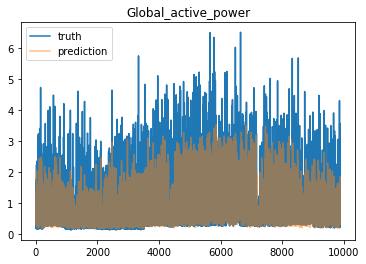

mae:  0.08460833
mape:  0.5992099
smape:  0.5021463
S2S_cnn_attn(
  (encoder): Encoder(
    (pooling): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
    (convs): ModuleList(
      (0): Conv1d(1, 4, kernel_size=(4,), stride=(1,))
      (1): Conv1d(1, 4, kernel_size=(4,), stride=(1,))
      (2): Conv1d(1, 4, kernel_size=(4,), stride=(1,))
      (3): Conv1d(1, 4, kernel_size=(4,), stride=(1,))
      (4): Conv1d(1, 4, kernel_size=(4,), stride=(1,))
      (5): Conv1d(1, 4, kernel_size=(4,), stride=(1,))
      (6): Conv1d(1, 4, kernel_size=(4,), stride=(1,))
    )
  )
  (decoder): Decoder(
    (rnn): GRU(1, 80, batch_first=True)
    (fc1): Linear(in_features=80, out_features=16, bias=True)
    (fc2): Linear(in_features=16, out_features=1, bias=True)
  )
)
Global_reactive_power
number of parmeters: 21373
epoch:0
training mae loss:0.22063573449850082
testing mae loss:0.22218653559684753
testing mape:0.88163406
epoch:100
training mae loss:0.08128401264548302
testing mae loss:0.09478889

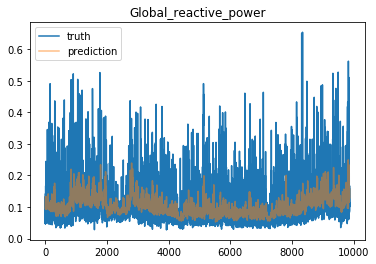

mae:  0.08936304
mape:  0.37471682
smape:  0.35907665
S2S_cnn_attn(
  (encoder): Encoder(
    (pooling): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
    (convs): ModuleList(
      (0): Conv1d(1, 4, kernel_size=(4,), stride=(1,))
      (1): Conv1d(1, 4, kernel_size=(4,), stride=(1,))
      (2): Conv1d(1, 4, kernel_size=(4,), stride=(1,))
      (3): Conv1d(1, 4, kernel_size=(4,), stride=(1,))
      (4): Conv1d(1, 4, kernel_size=(4,), stride=(1,))
      (5): Conv1d(1, 4, kernel_size=(4,), stride=(1,))
      (6): Conv1d(1, 4, kernel_size=(4,), stride=(1,))
    )
  )
  (decoder): Decoder(
    (rnn): GRU(1, 80, batch_first=True)
    (fc1): Linear(in_features=80, out_features=16, bias=True)
    (fc2): Linear(in_features=16, out_features=1, bias=True)
  )
)
Voltage
number of parmeters: 21373
epoch:0
training mae loss:0.8086146414279938
testing mae loss:0.8464694619178772
testing mape:0.08153377
epoch:100
training mae loss:0.09443405270576477
testing mae loss:0.0909150242805481
testi

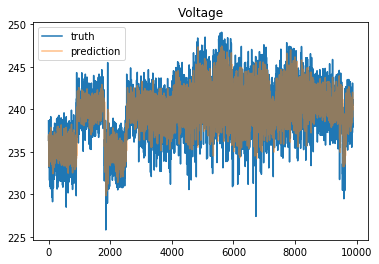

mae:  0.069130324
mape:  0.0066793165
smape:  0.0066751693
S2S_cnn_attn(
  (encoder): Encoder(
    (pooling): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
    (convs): ModuleList(
      (0): Conv1d(1, 4, kernel_size=(4,), stride=(1,))
      (1): Conv1d(1, 4, kernel_size=(4,), stride=(1,))
      (2): Conv1d(1, 4, kernel_size=(4,), stride=(1,))
      (3): Conv1d(1, 4, kernel_size=(4,), stride=(1,))
      (4): Conv1d(1, 4, kernel_size=(4,), stride=(1,))
      (5): Conv1d(1, 4, kernel_size=(4,), stride=(1,))
      (6): Conv1d(1, 4, kernel_size=(4,), stride=(1,))
    )
  )
  (decoder): Decoder(
    (rnn): GRU(1, 80, batch_first=True)
    (fc1): Linear(in_features=80, out_features=16, bias=True)
    (fc2): Linear(in_features=16, out_features=1, bias=True)
  )
)
Global_intensity
number of parmeters: 21373
epoch:0
training mae loss:0.12024320289492607
testing mae loss:0.10824770480394363
testing mape:1.0842004
epoch:100
training mae loss:0.09416025131940842
testing mae loss:0.0927982

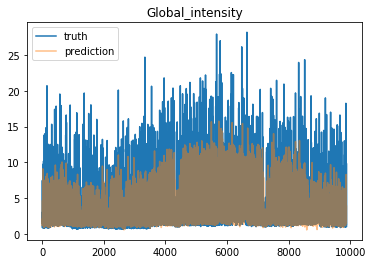

mae:  0.08060718
mape:  0.5732091
smape:  0.4887054


<Figure size 432x288 with 0 Axes>

In [9]:
import src.model

method='none'

targets=[0,1,2,3]
input_dim=7
cnn_hidden_size=4
cnn_kernel_size=4
cnn_parameters=(cnn_hidden_size,cnn_kernel_size)
fc_size=16
input_length=24
output_length=12

split=3096
num_epochs=5000
batch=5000

#attention_weights=[]

for i in targets:
    
    inputs=make_neighbor_list(i, input_dim)
    
    model=src.model.S2S_cnn_attn(cnn_parameters,fc_size,input_dim,input_length,output_length, method=method)
    print(model)
    
    X_train, Y_train, X_test, Y_test=train(data1, inputs,num_epochs,input_dim, input_length, output_length, split, model, objective, method)
    
    
    test_mae=util.mae(model(X_test)[:,:,0],Y_test[:,:,0])
    print('mae: ',test_mae)
    
    test_mape=util.mape(model(X_test)[:,:,0],Y_test[:,:,0],(scale[0][i]-scale[1][i]),scale[1][i])
    print('mape: ',test_mape)
    
    test_smape=util.smape(model(X_test)[:,:,0],Y_test[:,:,0],(scale[0][i]-scale[1][i]),scale[1][i])
    print('smape: ',test_smape)
    
    torch.save(model, path+ '/results/models/'+method+'/'+data.columns[i]+'.pt')
    #attention_weights.append(attns)

basic_S2S(
  (encoder): Encoder(
    (lstm): LSTM(7, 32)
  )
  (decoder): Decoder(
    (lstm): LSTM(1, 32)
    (fc1): Linear(in_features=32, out_features=16, bias=True)
    (fc2): Linear(in_features=16, out_features=1, bias=True)
  )
)
Global_active_power
number of parmeters: 10273
epoch:0
training mae loss:0.39953088760375977
testing mae loss:0.39067745208740234
testing mape:3.3103848
epoch:100
training mae loss:0.11141366884112358
testing mae loss:0.10420583933591843
testing mape:0.77101874
epoch:200
training mae loss:0.10488661378622055
testing mae loss:0.10016130656003952
testing mape:0.68277264
epoch:300
training mae loss:0.0950397439301014
testing mae loss:0.0943310409784317
testing mape:0.68480086
epoch:400
training mae loss:0.09415090084075928
testing mae loss:0.09166377782821655
testing mape:0.769467
epoch:500
training mae loss:0.09049384295940399
testing mae loss:0.09119201451539993
testing mape:0.6062845
epoch:600
training mae loss:0.08699706941843033
testing mae loss:0.0884

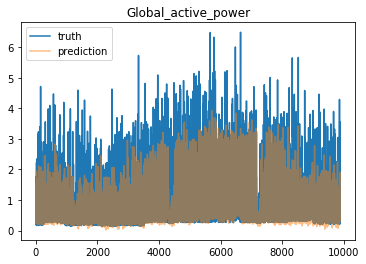

mae:  0.08348564
mape:  0.56552255
smape:  0.5026987
basic_S2S(
  (encoder): Encoder(
    (lstm): LSTM(7, 32)
  )
  (decoder): Decoder(
    (lstm): LSTM(1, 32)
    (fc1): Linear(in_features=32, out_features=16, bias=True)
    (fc2): Linear(in_features=16, out_features=1, bias=True)
  )
)
Global_reactive_power
number of parmeters: 10273
epoch:0
training mae loss:0.216157965362072
testing mae loss:0.22025573253631592
testing mape:0.8716826
epoch:100
training mae loss:0.08257537707686424
testing mae loss:0.09431712329387665
testing mape:0.3673449
epoch:200
training mae loss:0.08170786872506142
testing mae loss:0.09338858723640442
testing mape:0.36668906
epoch:300
training mae loss:0.08074640855193138
testing mae loss:0.09261498600244522
testing mape:0.3653919
epoch:400
training mae loss:0.07978062331676483
testing mae loss:0.09203629195690155
testing mape:0.36360213
epoch:500
training mae loss:0.07678820937871933
testing mae loss:0.08928579092025757
testing mape:0.3862174
epoch:600
traini

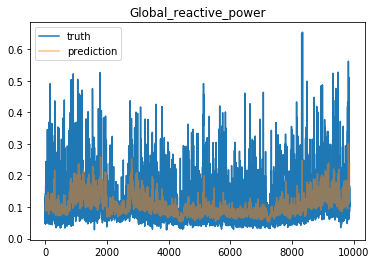

mae:  0.08942593
mape:  0.37733647
smape:  0.35936847
basic_S2S(
  (encoder): Encoder(
    (lstm): LSTM(7, 32)
  )
  (decoder): Decoder(
    (lstm): LSTM(1, 32)
    (fc1): Linear(in_features=32, out_features=16, bias=True)
    (fc2): Linear(in_features=16, out_features=1, bias=True)
  )
)
Voltage
number of parmeters: 10273
epoch:0
training mae loss:0.7242279946804047
testing mae loss:0.7773786187171936
testing mape:0.07486731
epoch:100
training mae loss:0.11408958584070206
testing mae loss:0.10283579677343369
testing mape:0.009885225
epoch:200
training mae loss:0.1072850190103054
testing mae loss:0.09979519993066788
testing mape:0.009593773
epoch:300
training mae loss:0.10142112895846367
testing mae loss:0.09497299045324326
testing mape:0.009133329
epoch:400
training mae loss:0.09721586480736732
testing mae loss:0.09052887558937073
testing mape:0.008711014
epoch:500
training mae loss:0.08552099764347076
testing mae loss:0.08472182601690292
testing mape:0.008191464
epoch:600
training ma

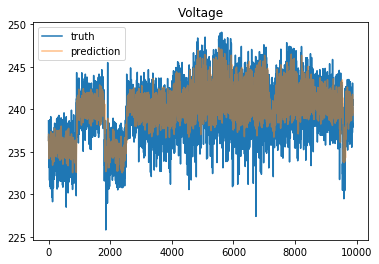

mae:  0.07328913
mape:  0.007079143
smape:  0.0070760897
basic_S2S(
  (encoder): Encoder(
    (lstm): LSTM(7, 32)
  )
  (decoder): Decoder(
    (lstm): LSTM(1, 32)
    (fc1): Linear(in_features=32, out_features=16, bias=True)
    (fc2): Linear(in_features=16, out_features=1, bias=True)
  )
)
Global_intensity
number of parmeters: 10273
epoch:0
training mae loss:0.35621486604213715
testing mae loss:0.3548923432826996
testing mape:2.9870512
epoch:100
training mae loss:0.11069987341761589
testing mae loss:0.10452008992433548
testing mape:0.76540667
epoch:200
training mae loss:0.10860869288444519
testing mae loss:0.10336387902498245
testing mape:0.7841469
epoch:300
training mae loss:0.10662981122732162
testing mae loss:0.10230035334825516
testing mape:0.73477554
epoch:400
training mae loss:0.10450191423296928
testing mae loss:0.10116919130086899
testing mape:0.68616676
epoch:500
training mae loss:0.0999964028596878
testing mae loss:0.09909144788980484
testing mape:0.8496418
epoch:600
traini

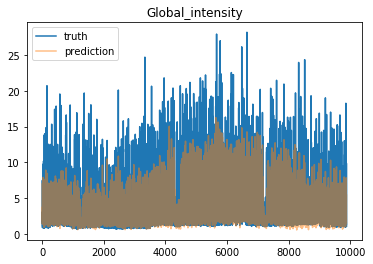

mae:  0.081889935
mape:  0.57729363
smape:  0.5003177


<Figure size 432x288 with 0 Axes>

In [11]:
import src.lstm_lstm

method=''

targets=[0,1,2,3]
input_dim=7
hidden_size=32
fc_size=16
input_length=24
output_length=12

split=3096
num_epochs=5000
batch=5000

#attention_weights=[]

for i in targets:
    
    inputs=make_neighbor_list(i, input_dim)
    
    model=src.lstm_lstm.basic_S2S(hidden_size, fc_size, input_length, input_dim, output_length)
    print(model)
    
    X_train, Y_train, X_test, Y_test=train(data1, inputs,num_epochs,input_dim, input_length, output_length, split, model, objective, method)
    
    
    test_mae=util.mae(model(X_test)[:,:,0],Y_test[:,:,0])
    print('mae: ',test_mae)
    
    test_mape=util.mape(model(X_test)[:,:,0],Y_test[:,:,0],(scale[0][i]-scale[1][i]),scale[1][i])
    print('mape: ',test_mape)
    
    test_smape=util.smape(model(X_test)[:,:,0],Y_test[:,:,0],(scale[0][i]-scale[1][i]),scale[1][i])
    print('smape: ',test_smape)
    
    torch.save(model, path+ '/results/models/lstm/'+data.columns[i]+'.pt')
    #attention_weights.append(attns)

S2S_2dcnn(
  (encoder): Encoder(
    (cnn): Conv2d(1, 4, kernel_size=(4, 7), stride=(1, 1))
    (rnn): GRU(4, 32, batch_first=True)
  )
  (decoder): Decoder(
    (rnn): GRU(1, 32, batch_first=True)
    (fc1): Linear(in_features=32, out_features=16, bias=True)
    (fc2): Linear(in_features=16, out_features=1, bias=True)
  )
)
Global_active_power
number of parmeters: 7669
epoch:0
training mae loss:0.11728613451123238
testing mae loss:0.10983362793922424
testing mape:0.7901353
epoch:100
training mae loss:0.10816379636526108
testing mae loss:0.10538872331380844
testing mape:0.7793267
epoch:200
training mae loss:0.1040256880223751
testing mae loss:0.10371454060077667
testing mape:0.73185164
epoch:300
training mae loss:0.10161015391349792
testing mae loss:0.10097644478082657
testing mape:0.69345796
epoch:400
training mae loss:0.09715412184596062
testing mae loss:0.09639996290206909
testing mape:0.7301586
epoch:500
training mae loss:0.09160879254341125
testing mae loss:0.09406301379203796
tes

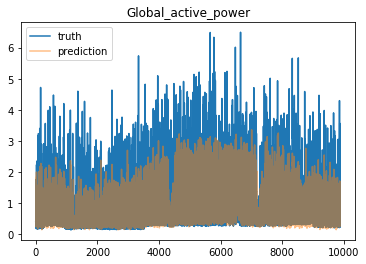

mae:  0.084942944
mape:  0.5878211
smape:  0.5081382
S2S_2dcnn(
  (encoder): Encoder(
    (cnn): Conv2d(1, 4, kernel_size=(4, 7), stride=(1, 1))
    (rnn): GRU(4, 32, batch_first=True)
  )
  (decoder): Decoder(
    (rnn): GRU(1, 32, batch_first=True)
    (fc1): Linear(in_features=32, out_features=16, bias=True)
    (fc2): Linear(in_features=16, out_features=1, bias=True)
  )
)
Global_reactive_power
number of parmeters: 7669
epoch:0
training mae loss:0.17431825399398804
testing mae loss:0.1811845898628235
testing mape:0.6601572
epoch:100
training mae loss:0.08278851211071014
testing mae loss:0.09430086612701416
testing mape:0.39682016
epoch:200
training mae loss:0.080879807472229
testing mae loss:0.09200865775346756
testing mape:0.3929578
epoch:300
training mae loss:0.08023282140493393
testing mae loss:0.0916026160120964
testing mape:0.39269596
epoch:400
training mae loss:0.07974961772561073
testing mae loss:0.09105141460895538
testing mape:0.39187068
epoch:500
training mae loss:0.07792

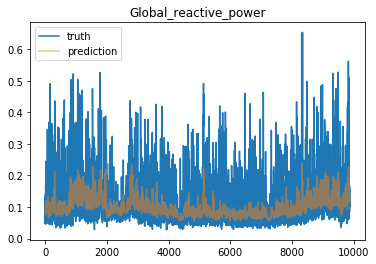

mae:  0.08885908
mape:  0.37740317
smape:  0.35829893
S2S_2dcnn(
  (encoder): Encoder(
    (cnn): Conv2d(1, 4, kernel_size=(4, 7), stride=(1, 1))
    (rnn): GRU(4, 32, batch_first=True)
  )
  (decoder): Decoder(
    (rnn): GRU(1, 32, batch_first=True)
    (fc1): Linear(in_features=32, out_features=16, bias=True)
    (fc2): Linear(in_features=16, out_features=1, bias=True)
  )
)
Voltage
number of parmeters: 7669
epoch:0
training mae loss:0.419145330786705
testing mae loss:0.4685537815093994
testing mape:0.045077782
epoch:100
training mae loss:0.10164472088217735
testing mae loss:0.0884687677025795
testing mape:0.0085408
epoch:200
training mae loss:0.09438730403780937
testing mae loss:0.08643008768558502
testing mape:0.008362832
epoch:300
training mae loss:0.09048621356487274
testing mae loss:0.08512295037508011
testing mape:0.008235893
epoch:400
training mae loss:0.08879052102565765
testing mae loss:0.08436093479394913
testing mape:0.008160028
epoch:500
training mae loss:0.0838664621114

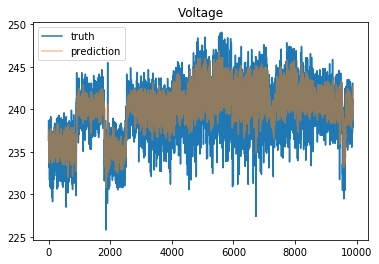

mae:  0.07650233
mape:  0.0073888716
smape:  0.007385972
S2S_2dcnn(
  (encoder): Encoder(
    (cnn): Conv2d(1, 4, kernel_size=(4, 7), stride=(1, 1))
    (rnn): GRU(4, 32, batch_first=True)
  )
  (decoder): Decoder(
    (rnn): GRU(1, 32, batch_first=True)
    (fc1): Linear(in_features=32, out_features=16, bias=True)
    (fc2): Linear(in_features=16, out_features=1, bias=True)
  )
)
Global_intensity
number of parmeters: 7669
epoch:0
training mae loss:0.1391371712088585
testing mae loss:0.12809878587722778
testing mape:0.55500656
epoch:100
training mae loss:0.10727715864777565
testing mae loss:0.1020079031586647
testing mape:0.7725783
epoch:200
training mae loss:0.10145498812198639
testing mae loss:0.09769567847251892
testing mape:0.6943436
epoch:300
training mae loss:0.09600994363427162
testing mae loss:0.09298810362815857
testing mape:0.67941695
epoch:400
training mae loss:0.08695332333445549
testing mae loss:0.08618102222681046
testing mape:0.63900626
epoch:500
training mae loss:0.0821

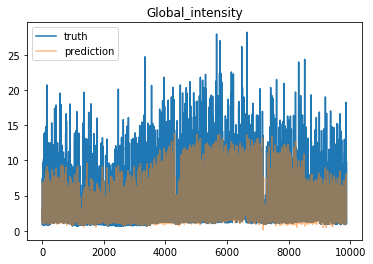

mae:  0.08090334
mape:  0.5626052
smape:  0.49213302


<Figure size 432x288 with 0 Axes>

In [13]:
import src.two_dim_cnn_gru

method=""

targets=[0,1,2,3]
input_dim=7

hidden_size=32
fc_size=16
input_length=24
output_length=12

cnn_hidden_size=4
cnn_kernel_size=4
cnn_parameters=(cnn_hidden_size,cnn_kernel_size)

split=3096
num_epochs=5000
batch=5000

#attention_weights=[]

for i in targets:
    
    inputs=make_neighbor_list(i, input_dim)
    
    #S2S_2dcnn(cnn_parameters,rnn_hidden_size,fc_size,input_dim,output_length)
    model=src.two_dim_cnn_gru.S2S_2dcnn(cnn_parameters,hidden_size,fc_size,input_dim,output_length)
    print(model)
    
    X_train, Y_train, X_test, Y_test=train(data1, inputs,num_epochs,input_dim, input_length, output_length, split, model, objective, method)
    
    test_mae=util.mae(model(X_test)[:,:,0],Y_test[:,:,0])
    print('mae: ',test_mae)
    
    test_mape=util.mape(model(X_test)[:,:,0],Y_test[:,:,0],(scale[0][i]-scale[1][i]),scale[1][i])
    print('mape: ',test_mape)
    
    test_smape=util.smape(model(X_test)[:,:,0],Y_test[:,:,0],(scale[0][i]-scale[1][i]),scale[1][i])
    print('smape: ',test_smape)
    # plot_attention(model, X_train, X_test, column_names, neighbors, save_path)
    #attns= util.plot_attention(model, X_train, X_test, data.columns, inputs, path+ '/results/plots/exchange_rate/')

    
    torch.save(model, path+ '/results/models/2dcnn/'+data.columns[i]+'.pt')
    #attention_weights.append(attns)

In [14]:
model

S2S_cnn_attn(
  (encoder): Encoder(
    (pooling): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
    (convs): ModuleList(
      (0): Conv1d(1, 4, kernel_size=(4,), stride=(1,))
      (1): Conv1d(1, 4, kernel_size=(4,), stride=(1,))
      (2): Conv1d(1, 4, kernel_size=(4,), stride=(1,))
      (3): Conv1d(1, 4, kernel_size=(4,), stride=(1,))
      (4): Conv1d(1, 4, kernel_size=(4,), stride=(1,))
      (5): Conv1d(1, 4, kernel_size=(4,), stride=(1,))
      (6): Conv1d(1, 4, kernel_size=(4,), stride=(1,))
    )
  )
  (decoder): Decoder(
    (rnn): GRU(1, 80, batch_first=True)
    (fc1): Linear(in_features=80, out_features=16, bias=True)
    (fc2): Linear(in_features=16, out_features=1, bias=True)
  )
)

# show results

In [16]:
i=1
method='dot'
file_name=data.columns[i]
model=torch.load(path+ '/results/models/'+method+'/'+file_name+'.pt')

In [17]:
split=3096
print(file_name)
inputs=make_neighbor_list(target=i, input_dim=7)

#make_io(input_len,output_len,neighbors,shuffle=True)
dataset1, dataset2=make_io(data1, input_len=24,output_len=12,neighbors=inputs, split_size=split ,shuffle=False)
X_train=torch.FloatTensor(dataset1[0])
X_test=torch.FloatTensor(dataset2[0])
Y_test=torch.FloatTensor(dataset2[1])[:,:,0].unsqueeze(2)

test_mae=util.mae(model(X_test)[:,:,0],Y_test[:,:,0])
print(test_mae)
test_mape=util.mape(model(X_test)[:,:,0],Y_test[:,:,0],(scale[0][i]-scale[1][i]),scale[1][i])
print(test_mape)

Global_reactive_power
0.08919214
0.37493753


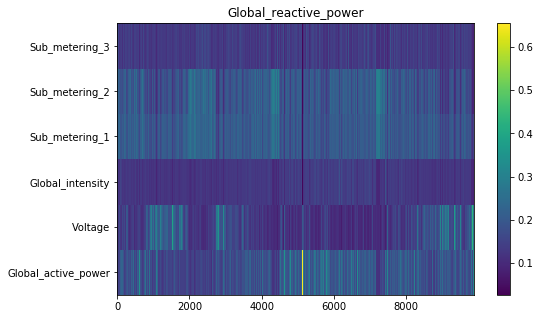

0 0.19882273477541035
2 0.14963675651496927
3 0.13085565211997913
4 0.19639492683559065
5 0.19055813282735143
6 0.1337317972150639


[[3, 0.12642274532174946],
 [6, 0.13347855809150763],
 [2, 0.16491221333884337],
 [5, 0.1884616860036367],
 [0, 0.1897542799975163],
 [4, 0.196970516494384]]

<Figure size 432x288 with 0 Axes>

In [18]:
attns= util.plot_attention(model, X_train, X_test, data.columns, inputs, path+ '/results/plots/household_consumption/'+method+'/')

attns=np.array(attns)
importance=[]
for k in range(1,7):
    print(inputs[k], attns[5587:,k-1].mean())
    importance.append([inputs[k], attns[6816:,k-1].mean()])
importance=sorted(importance, key= lambda importance: importance[1])
importance

# first/last performance

In [6]:

def first_last(method, step):
    #mae=0
    #smape=0
    mae=[]
    smape=[]
    for i in range(4):
        file_name=data.columns[i]
        model=torch.load(path+ '/results/models/'+method+'/'+file_name+'.pt')
        inputs=make_neighbor_list(target=i, input_dim=7)
        dataset1, dataset2=make_io(data1,input_len=24,output_len=12,neighbors=inputs, split_size=3096, shuffle=False)
        X_test=torch.FloatTensor(dataset2[0])
        Y_test=torch.FloatTensor(dataset2[1])[:,:,0].unsqueeze(2)
        mae.append(util.mae(model(X_test)[:,step,:],Y_test[:,step,:]))
        smape.append(util.smape(model(X_test)[:,step,:],Y_test[:,step,:],(scale[0][i]-scale[1][i]),scale[1][i]))
    return mae, smape
        #mae+=abs(model(X_test)[:,step,:]-Y_test[:,step,:]).mean()
        #smape+=util.smape(model(X_test)[:,step,:],Y_test[:,step,:],(scale[0][i]-scale[1][i]),scale[1][i])
    #return mae.item()/4, smape/4

In [7]:
model_names=['bahdanau','dot','general','none','lstm','2dcnn']
for name in model_names:
    first=first_last(name, 0)
    #last=first_last(name, -1)
    print(name, "mae:",np.mean(first[0]),"/",np.std(first[0]))
    print(name, "smape:",np.mean(first[1]),"/",np.std(first[1]))

/usr/bin/anaconda3/lib/python3.7/site-packages/torch/serialization.py:435: SourceChangeWarning: source code of class 'src.model.S2S_cnn_attn' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


bahdanau mae: 0.067889035 / 0.010590234
bahdanau smape: 0.28629708 / 0.16315454


/usr/bin/anaconda3/lib/python3.7/site-packages/torch/serialization.py:435: SourceChangeWarning: source code of class 'src.model.Encoder' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


dot mae: 0.06725136 / 0.010840944
dot smape: 0.2797541 / 0.15894693
general mae: 0.067503676 / 0.010316754
general smape: 0.2817139 / 0.16036911
none mae: 0.06698821 / 0.011608403
none smape: 0.28224885 / 0.16062519
lstm mae: 0.069334455 / 0.0088025015
lstm smape: 0.29471982 / 0.16919458
2dcnn mae: 0.069711536 / 0.0082122795
2dcnn smape: 0.28863558 / 0.16476645


In [8]:
model_names=['bahdanau','dot','general','none','lstm','2dcnn']
for name in model_names:
    #first=first_last(name, 0)
    last=first_last(name, -1)
    print(name, "mae:",np.mean(last[0]),"/",np.std(last[0]))
    print(name, "smape:",np.mean(last[1]),"/",np.std(last[1]))

bahdanau mae: 0.08581641 / 0.007873025
bahdanau smape: 0.36258242 / 0.21634124
dot mae: 0.0852337 / 0.0076292446
dot smape: 0.35823634 / 0.21334933
general mae: 0.08478479 / 0.008191001
general smape: 0.35846028 / 0.21342544
none mae: 0.0844097 / 0.007498908
none smape: 0.3534679 / 0.20975323
lstm mae: 0.08719546 / 0.004652464
lstm smape: 0.3576218 / 0.21128169
2dcnn mae: 0.08810444 / 0.0028473604
2dcnn smape: 0.3529055 / 0.20813882


In [6]:

def all_performance(method):
    #mae=0
    #smape=0
    mae=[]
    smape=[]
    for i in range(4):
        file_name=data.columns[i]
        model=torch.load(path+ '/results/models/'+method+'/'+file_name+'.pt')
        inputs=make_neighbor_list(target=i, input_dim=7)
        dataset1, dataset2=make_io(data1,input_len=24,output_len=12,neighbors=inputs, split_size=3096, shuffle=False)
        X_test=torch.FloatTensor(dataset2[0])
        Y_test=torch.FloatTensor(dataset2[1])[:,:,0].unsqueeze(2)
        mae.append(util.mae(model(X_test)[:,:,0],Y_test[:,:,0]))
        smape.append(util.smape(model(X_test)[:,:,0],Y_test[:,:,0],(scale[0][i]-scale[1][i]),scale[1][i]))
    return mae, smape
        #mae+=util.mae(model(X_test)[:,:,0],Y_test[:,:,0])
        #smape+=util.smape(model(X_test)[:,:,0],Y_test[:,:,0],(scale[0][i]-scale[1][i]),scale[1][i])
    #return mae.item()/4, smape/4

In [7]:
model_names=['bahdanau','dot','general','none','lstm','2dcnn']
all_mae=[]
all_smape=[]
for name in model_names:
    mae, smape=all_performance(name)
    all_mae.append(mae)
    all_smape.append(smape)
    #print(name, "mae:",first[0])
    #print(name, "smape:",first[1])

/usr/bin/anaconda3/lib/python3.7/site-packages/torch/serialization.py:435: SourceChangeWarning: source code of class 'src.model.S2S_cnn_attn' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/bin/anaconda3/lib/python3.7/site-packages/torch/serialization.py:435: SourceChangeWarning: source code of class 'src.model.Encoder' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


In [9]:
all_mae=pd.DataFrame(all_mae, index=model_names).transpose()
all_smape=pd.DataFrame(all_smape,index=model_names).transpose()

In [10]:
all_mae

,bahdanau,dot,general,none,lstm,2dcnn
0,0.085661,0.085740,0.085906,0.084608,0.083486,0.084943
1,0.089847,0.089192,0.089323,0.089363,0.089426,0.088859
2,0.069159,0.069232,0.068873,0.069130,0.073289,0.076502
3,0.081890,0.082531,0.082387,0.080607,0.081890,0.080903


In [11]:
all_mae.mean(), all_mae.std()

(bahdanau    0.081639
 dot         0.081674
 general     0.081622
 none        0.080927
 lstm        0.082023
 2dcnn       0.082802
 dtype: float64, bahdanau    0.008932
 dot         0.008729
 general     0.008959
 none        0.008641
 lstm        0.006664
 2dcnn       0.005309
 dtype: float64)

In [12]:
all_smape.mean(), all_smape.std()

(bahdanau    0.345522
 dot         0.342544
 general     0.343311
 none        0.339151
 lstm        0.342365
 2dcnn       0.341489
 dtype: float64, bahdanau    0.235990
 dot         0.233975
 general     0.234588
 none        0.230847
 lstm        0.233355
 2dcnn       0.232646
 dtype: float64)